In [1]:
%load_ext catalyst

In [2]:
# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline

In [462]:
#Distance approach (by Gatev)

from datetime import timedelta

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt


from catalyst import run_algorithm
from catalyst.api import (symbols, order, symbol, order_target_percent, order_percent, record)
from catalyst.exchange.utils.exchange_utils import get_exchange_symbols


def initialize(context):
    context.i = -1  # minute bar counter
    context.exchange = list(context.exchanges.values())[0].name.lower() #bitfinex
    context.quote_currency = list(
        context.exchanges.values())[0].quote_currency.lower()
    #STRATEGY
    # We need to make a matrix of UNIVERSE CLOSE prices for a given FORMATION_PERIOD and TRADING_PERIOD
    context.price = 'close' # we use 'close' to make computations 
    context.formation_period = 200 #in bars
    context.trading_period = 40 # in bars
#     context.number_of_trading_periods = 100 #number of periods we want to trade
    context.number_of_coins = 10 #number of TOP coins by VOLUME in universe we want to trade
    context.number_of_pairs = 5 #number of coin pairs we want to form
    context.minutes = 60
    context.frequency = '{}T'.format(context.minutes)
    context.tp_count = -1
    context.pairs_universe = None
    context.std_open_mult = 2
    context.std_sl_mult = 3 
    context.std_close_mult = 0.5
    context.explicit_coins = ['btc_usd', 'eth_usd', 'xrp_usd', 'ltc_usd', 'eos_usd', 'iot_usd', 'neo_usd', 'etc_usd', 'zec_usd', 'dsh_usd', 'xmr_usd', 'trx_usd']
    context.set_commission(maker=0.000, taker=0.000)

def handle_data(context, data):
    #minute counter
    context.i += 1
    #FORMATION LOGIC
    if data.current_dt <= pd.to_datetime('2018-05-01', utc=True):
        return
#     #We skip first FP bars
#     if context.i < context.formation_period*context.minutes:
#         return
    #Every beginning of TP we look FP bars ago and get universe of existing assets for this period.
    if context.i % (context.trading_period*context.minutes) == 0:
        now = data.current_dt
        past = now - timedelta(minutes=context.formation_period*context.minutes)
#         context.universe = universe_pt(context, now, past)  #form universe (list of assets to upload in history)
#         context.universe.remove('ust_usd')# we drop pair ust_usd
#         context.universe.remove('pax_usd')# we drop pair pax_usd
        context.coins = symbols(*context.explicit_coins)  # convert all the pairs to SYMBOLS format which is necessary for data.history
        #To simplify computation, we want to reduce our UNIVERSE according to rule of highest volume in a day
        yesterday_volume = data.history(context.coins,'volume',bar_count=2,frequency='1D')[0:1].T #we get volume in BASE currency
        yesterday_close = data.history(context.coins,'close',bar_count=2,frequency='1D')[0:1].T
#         non_stable = abs(yesterday_close[yesterday_close.columns[0]]-1) > 0.3 # we use condition to eleminate stable coins
#         yesterday_volume = yesterday_volume[non_stable]*yesterday_close[non_stable] #we convert volume into quote currency terms
        yesterday_volume = yesterday_volume.nlargest(context.number_of_coins, columns=yesterday_volume.columns[0]) # we pick only high traded coins
        context.coins_reduced = list(yesterday_volume.index) # the same as making by symbols function
        #close positions if they open
        for coin in context.portfolio.positions:
            order_target_percent(coin, 0)
#             print(coin.symbol, ':', context.portfolio.positions[coin].amount, 'sold out')
        display(context.portfolio.portfolio_value)

    if context.i % (context.trading_period*context.minutes) == 0:  
        #1)we take prices
        context.close = data.history(context.coins_reduced,'close',bar_count=context.formation_period,frequency=context.frequency)
        #2)then we normalize them
        context.close_norm = context.close/context.close.iloc[0,:]
        #3)then we make all possible spreads
        context.pairs_spread = pd.DataFrame(index=context.close_norm.index)
        context.pairs_spread_dm = pd.DataFrame(index=['dm']) # dm is for distance measure
        for i,j in itertools.combinations(context.close_norm.columns,2):           
            context.pairs_spread[(i,j)] = context.close_norm[i] - context.close_norm[j]
            #4) Compute measure of distance for each spread:
            context.pairs_spread_dm[(i,j)] = pd.Series(context.pairs_spread[(i,j)]**2).sum()
        context.full_universe = context.pairs_spread_dm.columns
        # 5) now we reduce universe to top NUMBER_OF_PAIRS pairs according by lowest distance measure:
        context.pairs_universe = list(context.pairs_spread_dm.sort_values(by='dm', axis=1).columns[: context.number_of_pairs])
        
        period_number = (context.i - context.formation_period*context.minutes) / (context.trading_period*context.minutes)
#         record(pairs_traded = context.pairs_universe, period_number = period_number)
        print(data.current_dt, context.i)
        
#         display(context.i, close, close_norm, pairs_spread_dm, pairs_spread, pairs_spread_dm.sort_values(by='dm', axis=1))
        # 6) we create empty dataset for future trading data
        context.dataset = pd.DataFrame(index=range(context.trading_period), columns=context.pairs_universe) 
        context.full_dataset = pd.DataFrame(index=range(context.trading_period), columns=context.full_universe)
        # 7) and compute all standard deviations for trading logic
        for pair in context.pairs_universe:
            context.dataset.loc['std', pair] = context.pairs_spread[pair].std()
            context.full_dataset.loc['std', pair] = context.pairs_spread[pair].std()
#             plt.figure()
#             plt.plot(pairs_spread[pair])
#             plt.axhline(y=context.dataset[pair].loc['std'], color='r', linestyle='-')
#             plt.show()
#         display(context.dataset)
        #for positions: long or short
        context.pos = pd.DataFrame(index = range(context.trading_period), columns=context.pairs_universe)
        context.pos.iloc[0] = 0
        #for bans of long or short
        context.pos_ban = pd.DataFrame(index = range(context.trading_period), columns=context.pairs_universe)
        #for orders logic. id of transaction to close further.
        context.transactions_open = pd.DataFrame(index=(0,1), columns=context.pairs_universe)
#         display(np.isnan(context.pos_ban.iloc[0,0]))


        
    #TRADING LOGIC
    
    if context.i % context.minutes == 0 and context.pairs_universe: #we trade each CONTEXT.MINUTES minutes and need pairs_universe to exist
        context.tp_count = int(context.i%(context.trading_period*context.minutes)/context.minutes) # goes from 0 to (context.trading_period - 1)
#         display(context.tp_count)
        for pair in context.dataset.columns: # here pair contains TWO coins
            context.current_price = data.current(pair, context.price) 
            context.first_price = data.history(pair,context.price,bar_count=context.tp_count+1,frequency=context.frequency).iloc[0,:]
            context.norm_price = context.current_price/context.first_price
            context.dataset.loc[context.tp_count, pair] = context.norm_price[0] - context.norm_price[1] # here we get pair spread
#             display(context.std_open_mult*context.dataset[pair].loc[context.tp_count], 'std: ', context.dataset[pair].loc['std'])
#             context.full_dataset.loc[context.tp_count, pair] = context.norm_price[0] - context.norm_price[1] 
            #Check if it's not 0 bar of trading (it is the bar when we form our pairs_universe)
            if context.tp_count>0:
                #we explicitly assign current position as previous
                context.pos.loc[context.tp_count, [pair]] = context.pos.loc[context.tp_count-1, [pair]]
                context.pos_ban.loc[context.tp_count, [pair]] = context.pos_ban.loc[context.tp_count-1, [pair]]
                # then we start to manipulate with current positions if they comply with some conditions
                
                #if BAN
                if type(context.pos_ban[pair].loc[context.tp_count])==str:
                    if (context.pos_ban[pair].loc[context.tp_count]=='short' and 
                           context.dataset[pair].loc[context.tp_count] < context.std_open_mult*context.dataset[pair].loc['std']):
                        context.pos_ban.loc[context.tp_count, pair] = np.nan
                        print(context.i, 'unban of short: {}, {}'.format(pair[0], pair[1]))
                    elif (context.pos_ban[pair].loc[context.tp_count]=='long' and 
                           context.dataset[pair].loc[context.tp_count] > -context.std_open_mult*context.dataset[pair].loc['std']):
                        context.pos_ban.loc[context.tp_count, pair] = np.nan
                        print(context.i, 'unban of long: {}, {}'.format(pair[0], pair[1]))
                
                #If NO POSITION:
                if context.pos[pair].loc[context.tp_count] == 0 and pd.isnull(context.pos_ban[pair].loc[context.tp_count]):
                    #SHORT SPREAD
                    if (context.dataset[pair].loc[context.tp_count] > context.std_open_mult*context.dataset[pair].loc['std']):
                        print(context.i, 'short {} long {}'.format(pair[0], pair[1]))
                        context.pos.loc[context.tp_count, pair] = -1
                    #LONG SPREAD    
                    elif (context.dataset[pair].loc[context.tp_count] < -context.std_open_mult*context.dataset[pair].loc['std']):
                        print(context.i, 'long {} short {}'.format(pair[0], pair[1]))
                        context.pos.loc[context.tp_count, pair] = 1
                #If SHORT POSITION:
                if context.pos[pair].loc[context.tp_count] == -1:
                    #TAKE PROFIT SHORT
                    if context.dataset[pair].loc[context.tp_count] < context.std_close_mult*context.dataset[pair].loc['std']:
                        print(context.i, 'take profit of short: {}, {}'.format(pair[0], pair[1])) 
                        context.pos.loc[context.tp_count, pair] = 0
                    #STOP-LOSS SHORT
                    elif context.dataset[pair].loc[context.tp_count] > context.std_sl_mult*context.dataset[pair].loc['std']:
                        print(context.i, 'stop-loss of short: {}, {}'.format(pair[0], pair[1])) 
                        context.pos.loc[context.tp_count, pair] = 0
                        context.pos_ban.loc[context.tp_count,pair] = 'short'
                #If LONG POSITION:
                if context.pos[pair].loc[context.tp_count] == 1:
                    #TAKE PROFIT LONG
                    if context.dataset[pair].loc[context.tp_count] > -context.std_close_mult*context.dataset[pair].loc['std']:
                        print(context.i, 'take profit of long: {}, {}'.format(pair[0], pair[1])) 
                        context.pos.loc[context.tp_count,pair] = 0
                    #STOP-LOSS LONG
                    elif context.dataset[pair].loc[context.tp_count] < -context.std_sl_mult*context.dataset[pair].loc['std']:
                        print(context.i, 'stop-loss of long: {}, {}'.format(pair[0], pair[1])) 
                        context.pos.loc[context.tp_count, pair] = 0
                        context.pos_ban.loc[context.tp_count, pair] = 'long'

        record(spread_dataset = context.full_dataset.loc[context.tp_count,:],
                  std_dataset = context.full_dataset.loc['std',:],
                      pos_dataset = context.pos.loc[context.tp_count,:],
                          pos_ban_dataset = context.pos_ban.loc[context.tp_count,:],
                              btc=data.current(symbol('btc_usd'), 'price'))
#         display(context.tp_count, context.i, context.pos, context.pos_ban, context.dataset)

    #ORDER LOGIC
    if (context.tp_count>0 and 
            not context.pos.loc[context.tp_count].equals(context.pos.loc[context.tp_count-1]) and 
                context.i % context.minutes == 0):
        #difference between current postitions and previous
        difference = context.pos.loc[context.tp_count] - context.pos.loc[context.tp_count-1]
        #we leave only changed positions
        difference = difference[difference!=0]
        for pair in difference.index:
            #if we don't have to close previous open positions
            if pd.isnull(context.transactions_open[pair].loc[0]):
                # we write id of each opening position
                context.transactions_open.loc[0,pair]  = order_percent(pair[0], (1/context.number_of_pairs)*difference[pair])
                context.transactions_open.loc[1,pair]  = order_percent(pair[1], -(1/context.number_of_pairs)*difference[pair])
            else:
                # we want to close opened positions
                order(pair[0], -float(context.blotter.orders[context.transactions_open[pair].loc[0]].amount))
                order(pair[1], -float(context.blotter.orders[context.transactions_open[pair].loc[1]].amount))
                context.transactions_open[pair] = np.nan
                
#             print(context.transactions_open[pair])
#         display(context.i, data.current_dt, context.portfolio.positions)
        # end trading at the end of TP:        
    if context.tp_count == context.trading_period-1 and (context.i % context.minutes) == 0 and context.pairs_universe:
#         context.close = data.history(context.coins_reduced,'close',bar_count=context.trading_period,frequency=context.frequency)
#         #2)then we normalize them
#         context.close_norm = context.close/context.close.iloc[0,:]
#         #3)then we make all possible spreads
#         context.pairs_spread = pd.DataFrame(index=context.close_norm.index)
#         context.pairs_spread_dm = pd.DataFrame(index=['dm']) # dm is for distance measure
#         for i,j in itertools.combinations(context.close_norm.columns,2):           
#             context.pairs_spread[(i,j)] = context.close_norm[i] - context.close_norm[j]
            #4) Compute measure of distance for each spread:
#             context.pairs_spread_dm[(i,j)] = pd.Series(context.pairs_spread[(i,j)]**2).sum()
#         for pair in context.pairs_universe:
#             sec1 = pair[0].symbol.upper()
#             sec2 = pair[1].symbol.upper()
#             fig, ax = plt.subplots(3,1, figsize=(15,12)) 
#             ax[0].plot(context.close[pair[0]], 'r-', label=sec1)
#             ax[0].plot(context.close[pair[1]], 'b-', label=sec2)
#             ax[0].set_ylim([0,10])
#             ax[0].title.set_text('Prices of 2 cointegrated securities')
#             ax[0].legend(loc='best')
#             ax[1].plot(context.close_norm[pair[0]], 'r-', label=sec1)
#             ax[1].plot(context.close_norm[pair[1]], 'b-', label=sec2)
#             ax[1].legend(loc='best')
#             ax[1].set_ylim([0.8,1.2])
#             ax[1].title.set_text('Normalized prices 2 cointegrated securities')
#             ax[2].plot(context.pairs_spread[pair], label='Spread')
#             ax[2].axhline(context.dataset[pair].loc['std'], color='r', linestyle='-.', label='Bounds')
#             ax[2].axhline(-context.dataset[pair].loc['std'], color='r', linestyle='-.')
#             ax[2].legend(loc='best') 
#             ax[2].title.set_text('Spread with upper and lower bounds')
#             ax[2].set_ylim([-0.2,0.2])
#             plt.subplots_adjust(hspace=0.4)
#             ax[1,1].plot(context.pos[pair], label='Positions')
#             ax[1,1].legend(loc='best') 
#             plt.show(fig)
        context.pairs_universe = None
#         print(context.i, 'End of trading period')
#         display(context.tp_count, context.i, context.pos, context.pos_ban, context.dataset)
#         display(context.blotter.orders)
    
def analyze(context=None, results=None):
    pass


# Get the universe for a given exchange and a given quote_currency market
# Example: Poloniex BTC Market
def universe_pt(context, now, past):
    # get all the pairs for the given exchange
    json_symbols = get_exchange_symbols(context.exchange)
    df_universe = pd.DataFrame.from_dict(json_symbols).transpose()
#     display(df_universe[df_universe['symbol'] == context.quote_currency])
    df_universe['quote_currency'] = df_universe.apply(lambda row: row.symbol.split('_')[1],
                                    axis=1)
    df_universe['base_currency'] = df_universe.apply(lambda row: row.symbol.split('_')[0],
                                   axis=1)
    # Filter all the pairs to get only the ones for a given quote_currency
    df_universe = df_universe[df_universe['quote_currency'] == context.quote_currency]
    # Check if type of each row is pd.tslib.Timestamp, drop otherwise.
    df_universe = df_universe[df_universe.end_minute.apply(isinstance, args=(pd.tslib.Timestamp,))]
    df_universe = df_universe[df_universe.start_date.apply(isinstance, args=(pd.tslib.Timestamp,))]
    df_universe = df_universe[df_universe.end_minute > now]
    df_universe = df_universe[df_universe.start_date < past]
    return df_universe.symbol.tolist()

# Replace all NA, NAN or infinite values with its nearest value
def fill(series):
    if isinstance(series, pd.Series):
        return series.replace([np.inf, -np.inf], np.nan).ffill().bfill()
    elif isinstance(series, np.ndarray):
        return pd.Series(series).replace(
                     [np.inf, -np.inf], np.nan
                    ).ffill().bfill().values
    else:
        return series


if __name__ == '__main__':
    start_date = pd.to_datetime('2018-04-20', utc=True)
    end_date = pd.to_datetime('2019-05-01', utc=True)

    performance = run_algorithm(start=start_date, end=end_date,
                                capital_base=100.0,  # amount of quote_currency
                                initialize=initialize,
                                handle_data=handle_data,
                                analyze=analyze,
                                exchange_name='bitfinex',
                                data_frequency='minute',
                                quote_currency='usd',
                                live=False,
                                live_graph=False,
                                algo_namespace='simple_universe')

[2019-06-10 16:26:25.072673] INFO: run_algo: Catalyst version 0.5.21
[2019-06-10 16:26:25.082094] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-06-10 16:26:28.088694] INFO: run_algo: running algo in backtest mode
[2019-06-10 16:26:28.159010] INFO: exchange_algorithm: initialized trading algorithm in backtest mode


100.0

2018-05-01 16:00:00+00:00 16800
18900 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
18900 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])
18960 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])


99.67522116123781

2018-05-03 08:00:00+00:00 19200
19560 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
19560 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
19620 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
19860 unban of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
19980 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
20220 take profit of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
20280 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
20640 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
20640 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
20700 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
20700 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
20700 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd]

101.45389837878304

2018-05-05 00:00:00+00:00 21600
22500 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
22500 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
22500 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
23100 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
23100 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
23100 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
23400 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
23400 unban of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
23460 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
23760 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])


101.61420812335591

2018-05-06 16:00:00+00:00 24000
24780 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])


101.86887887610929

2018-05-08 08:00:00+00:00 26400
27600 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
27660 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])


102.2645166346041

2018-05-10 00:00:00+00:00 28800
29580 long TradingPair(125865 [neo_usd]) short TradingPair(909928 [xmr_usd])
30660 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(909928 [xmr_usd])
30720 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
30720 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
30720 long TradingPair(657702 [trx_usd]) short TradingPair(909928 [xmr_usd])
31140 unban of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])


101.56661700813285

2018-05-11 16:00:00+00:00 31200
32460 short TradingPair(657702 [trx_usd]) long TradingPair(909928 [xmr_usd])
32700 take profit of short: TradingPair(657702 [trx_usd]), TradingPair(909928 [xmr_usd])


102.63886515326752

2018-05-13 08:00:00+00:00 33600
34020 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])
34080 long TradingPair(125865 [neo_usd]) short TradingPair(587847 [xrp_usd])
34140 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
34140 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [xmr_usd])
34260 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
34380 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
34800 unban of short: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
34860 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])
35220 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
35460 unban of short: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
35640 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [xmr_usd])


102.14907140082155

2018-05-15 00:00:00+00:00 36000
37200 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
37320 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
37380 short TradingPair(98871 [btc_usd]) long TradingPair(909928 [xmr_usd])


102.4536526234032

2018-05-16 16:00:00+00:00 38400


102.43847284945323

2018-05-18 08:00:00+00:00 40800
41400 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])
41400 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
42180 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
42540 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])


103.94183786055495

2018-05-20 00:00:00+00:00 43200


103.94183786055495

2018-05-21 16:00:00+00:00 45600
47340 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
47820 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])


103.76375828770456

2018-05-23 08:00:00+00:00 48000
48240 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])
48600 long TradingPair(271832 [etc_usd]) short TradingPair(909928 [xmr_usd])
48720 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
48840 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
49080 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
49260 unban of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
49500 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])
49560 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
49560 short TradingPair(587847 [xrp_usd]) long TradingPair(909928 [xmr_usd])


104.29642167872211

2018-05-25 00:00:00+00:00 50400
50820 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
50820 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
50880 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
51360 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
51660 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
52200 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])


105.71955949412879

2018-05-26 16:00:00+00:00 52800
53580 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
54000 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
54180 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
55020 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
55080 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])
55080 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
55080 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])


106.06408306428924

2018-05-28 08:00:00+00:00 55200
56100 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])
56160 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
56160 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
56340 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
56700 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
56760 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
56820 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
56820 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
56820 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
56820 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
56880 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
56880 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_us

106.10987246080492

2018-05-30 00:00:00+00:00 57600
59340 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
59580 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])
59640 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])


105.84887614602556

2018-05-31 16:00:00+00:00 60000
61020 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
61020 long TradingPair(98871 [btc_usd]) short TradingPair(125865 [neo_usd])
61440 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
62040 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
62100 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
62100 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(125865 [neo_usd])


106.15663044893482

2018-06-02 08:00:00+00:00 62400
63900 long TradingPair(125865 [neo_usd]) short TradingPair(587847 [xrp_usd])
63900 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
64140 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
64200 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
64440 unban of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
64560 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
64680 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])


104.89142505074791

2018-06-04 00:00:00+00:00 64800
65220 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
65520 long TradingPair(271832 [etc_usd]) short TradingPair(347956 [ltc_usd])
65520 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
66420 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])


104.71800205846876

2018-06-05 16:00:00+00:00 67200


104.6985833389837

2018-06-07 08:00:00+00:00 69600
71040 short TradingPair(271832 [etc_usd]) long TradingPair(347956 [ltc_usd])
71040 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
71100 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [xmr_usd])
71400 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
71820 short TradingPair(98871 [btc_usd]) long TradingPair(909928 [xmr_usd])


104.51671977794969

2018-06-09 00:00:00+00:00 72000
73560 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [xmr_usd])


104.70911748838316

2018-06-10 16:00:00+00:00 74400
74520 short TradingPair(125865 [neo_usd]) long TradingPair(265391 [zec_usd])
74700 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
74760 long TradingPair(271832 [etc_usd]) short TradingPair(347956 [ltc_usd])
74760 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
74760 long TradingPair(271832 [etc_usd]) short TradingPair(657702 [trx_usd])
74760 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
74820 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
74820 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(657702 [trx_usd])
74820 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
74880 unban of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
75840 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
76020 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(265391 [zec_us

106.17351055540276

2018-06-12 08:00:00+00:00 76800
77520 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
77700 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
77880 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
77940 take profit of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
78000 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
78120 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
78300 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
78600 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
78660 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])
78660 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
78660 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
78900 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd

108.30692093475719

2018-06-14 00:00:00+00:00 79200
79500 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
79560 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
79680 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
79800 take profit of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
79920 long TradingPair(125865 [neo_usd]) short TradingPair(909928 [xmr_usd])
79980 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
79980 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
80220 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
80220 unban of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
80220 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
80280 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
80280 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
80280

111.09433964763002

2018-06-15 16:00:00+00:00 81600
82440 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
82440 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
83460 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])


111.69642465984978

2018-06-17 08:00:00+00:00 84000
85740 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
86100 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])


111.95186874574372

2018-06-19 00:00:00+00:00 86400
87120 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])
87360 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])


112.18428129760309

2018-06-20 16:00:00+00:00 88800


112.171897225501

2018-06-22 08:00:00+00:00 91200
91680 long TradingPair(652614 [iot_usd]) short TradingPair(909928 [xmr_usd])
92880 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])
92940 long TradingPair(125865 [neo_usd]) short TradingPair(909928 [xmr_usd])
93000 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(909928 [xmr_usd])
93060 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])
93480 unban of long: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])
93480 unban of long: TradingPair(125865 [neo_usd]), TradingPair(909928 [xmr_usd])
93540 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])


110.72493234841062

2018-06-24 00:00:00+00:00 93600
93840 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
94320 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
94320 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
94320 long TradingPair(125865 [neo_usd]) short TradingPair(587847 [xrp_usd])
94380 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
94560 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
94620 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
95220 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
95760 unban of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
95820 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
95940 unban of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])


108.989653614439

2018-06-25 16:00:00+00:00 96000
97920 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])


109.28224795508656

2018-06-27 08:00:00+00:00 98400
98880 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
99000 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
99300 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])


110.37247178333484

2018-06-29 00:00:00+00:00 100800
102060 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
102060 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
102120 unban of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
102180 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
102180 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
102180 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
102180 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
102660 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
102660 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])


110.39682006462252

2018-06-30 16:00:00+00:00 103200
103860 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
104040 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])
104160 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
104220 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
104400 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
104640 short TradingPair(125865 [neo_usd]) long TradingPair(657702 [trx_usd])
105060 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
105420 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])


109.43562611560054

2018-07-02 08:00:00+00:00 105600
106020 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
106020 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
106260 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
106320 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
106740 long TradingPair(347956 [ltc_usd]) short TradingPair(652614 [iot_usd])
106800 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
106860 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
106860 unban of short: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
106980 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
107760 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
107940 unban of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])


109.94263146063605

2018-07-04 00:00:00+00:00 108000
108720 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
108780 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
110160 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])


109.75148989812875

2018-07-05 16:00:00+00:00 110400


109.74925082780105

2018-07-07 08:00:00+00:00 112800
114720 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])


109.80452827357573

2018-07-09 00:00:00+00:00 115200
116160 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
116340 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
116340 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
116460 take profit of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
116580 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
116640 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
116820 long TradingPair(347956 [ltc_usd]) short TradingPair(587847 [xrp_usd])
116880 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
117060 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
117060 short TradingPair(587847 [xrp_usd]) long TradingPair(909928 [xmr_usd])
117060 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
117480 short TradingPair(347956 [ltc_usd]) long TradingPair(9

112.21700509368164

2018-07-10 16:00:00+00:00 117600
118620 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
118800 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
118920 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
119040 take profit of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
119100 short TradingPair(347956 [ltc_usd]) long TradingPair(909928 [xmr_usd])
119220 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
119520 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
119700 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])


113.232393036463

2018-07-12 08:00:00+00:00 120000
121020 short TradingPair(347956 [ltc_usd]) long TradingPair(909928 [xmr_usd])
121500 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
121860 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])


114.15560135088973

2018-07-14 00:00:00+00:00 122400


114.11950231986978

2018-07-15 16:00:00+00:00 124800
125880 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
125880 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
125880 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
125880 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
125940 unban of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
126000 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
126060 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
126300 unban of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
126720 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])
126960 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])


114.13125940721885

2018-07-17 08:00:00+00:00 127200
127800 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
127800 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
127860 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
127860 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
128340 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
128340 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
128400 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
128460 short TradingPair(347956 [ltc_usd]) long TradingPair(587847 [xrp_usd])
129360 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])
129420 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(587847 [xrp_usd])
129480 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])


113.5324147176677

2018-07-19 00:00:00+00:00 129600
130380 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
130620 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
130620 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
131100 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
131100 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
131220 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
131400 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
131460 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])


112.70296517264198

2018-07-20 16:00:00+00:00 132000
132240 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])
132420 take profit of long: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
133020 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
133320 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])


114.12716033864511

2018-07-22 08:00:00+00:00 134400


114.11810240771398

2018-07-24 00:00:00+00:00 136800
137220 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
137340 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
137580 unban of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
137640 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
137640 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
137700 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
137820 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])
138120 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
138240 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
138540 unban of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
138600 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
138600 short TradingPair(333257 [eos_usd]) long TradingPair(347

114.1852523882558

2018-07-25 16:00:00+00:00 139200
140160 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
140220 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])
140520 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
140640 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
141060 unban of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
141120 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])


113.89834503945963

2018-07-27 08:00:00+00:00 141600


113.89518902293574

2018-07-29 00:00:00+00:00 144000
144420 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])
144780 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
145920 unban of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
145920 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])
146100 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])
146160 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])


113.10723491204351

2018-07-30 16:00:00+00:00 146400
147120 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
147480 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
147540 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
147540 long TradingPair(125865 [neo_usd]) short TradingPair(587847 [xrp_usd])
147600 unban of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
147660 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
147900 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
148020 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
148500 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])


113.10632351114378

2018-08-01 08:00:00+00:00 148800
148860 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
150480 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
150480 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])


114.03810059800804

2018-08-03 00:00:00+00:00 151200
151380 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])
151500 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
151800 short TradingPair(32597 [eth_usd]) long TradingPair(265391 [zec_usd])
151980 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
152280 unban of long: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
152340 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(265391 [zec_usd])
152340 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])
152400 short TradingPair(32597 [eth_usd]) long TradingPair(265391 [zec_usd])
152400 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
152700 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(265391 [zec_usd])
152700 unban of long: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
152760 long TradingPair(125865 [neo_usd]) short TradingPair(33

114.28820341297464

2018-08-04 16:00:00+00:00 153600
153720 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
154200 long TradingPair(347956 [ltc_usd]) short TradingPair(652614 [iot_usd])
154200 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
154200 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
154200 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
154260 unban of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
154380 unban of long: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
154440 long TradingPair(347956 [ltc_usd]) short TradingPair(652614 [iot_usd])
154440 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
154440 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
154440 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
155220 take profit of short: TradingPair(32597 [eth_usd]), TradingPai

114.92907861759707

2018-08-06 08:00:00+00:00 156000
156240 long TradingPair(125865 [neo_usd]) short TradingPair(265391 [zec_usd])
156540 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
156840 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
157200 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(265391 [zec_usd])
158220 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])
158220 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
158220 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])


112.93856200771052

2018-08-08 00:00:00+00:00 158400
158640 short TradingPair(32597 [eth_usd]) long TradingPair(333257 [eos_usd])
158640 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
158640 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
158700 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
159480 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
160200 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
160380 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
160380 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
160740 unban of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
160740 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])


113.06034038485511

2018-08-09 16:00:00+00:00 160800
161700 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])
161940 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
162420 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
162840 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])
162840 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
162960 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
163080 take profit of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])


112.94114786294608

2018-08-11 08:00:00+00:00 163200
163740 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
163740 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
163800 long TradingPair(657702 [trx_usd]) short TradingPair(909928 [xmr_usd])
163860 stop-loss of long: TradingPair(657702 [trx_usd]), TradingPair(909928 [xmr_usd])
163920 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
164100 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
164160 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
164280 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
164520 short TradingPair(347956 [ltc_usd]) long TradingPair(909928 [xmr_usd])
165000 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
165120 short TradingPair(347956 [ltc_usd]) long TradingPair(909928 [xmr_usd])


113.27791665890089

2018-08-13 00:00:00+00:00 165600
166200 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
166320 long TradingPair(657702 [trx_usd]) short TradingPair(909928 [xmr_usd])
166560 long TradingPair(32597 [eth_usd]) short TradingPair(909928 [xmr_usd])
166620 stop-loss of long: TradingPair(657702 [trx_usd]), TradingPair(909928 [xmr_usd])
166620 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
166620 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])
166920 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
166980 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
167040 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
167220 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
167280 unban of short: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
167280 unban of long: TradingPair(125865 [neo_usd]), Trading

110.85102115562657

2018-08-14 16:00:00+00:00 168000
168480 short TradingPair(32597 [eth_usd]) long TradingPair(176889 [dsh_usd])
168540 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(176889 [dsh_usd])
168600 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
169380 short TradingPair(176889 [dsh_usd]) long TradingPair(347956 [ltc_usd])
169620 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
169800 long TradingPair(32597 [eth_usd]) short TradingPair(176889 [dsh_usd])
169800 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
169920 stop-loss of short: TradingPair(176889 [dsh_usd]), TradingPair(347956 [ltc_usd])
170280 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])


112.90780350890239

2018-08-16 08:00:00+00:00 170400
171120 short TradingPair(271832 [etc_usd]) long TradingPair(333257 [eos_usd])
171300 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(333257 [eos_usd])
171360 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
171480 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
171540 unban of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
171780 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
171780 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
171900 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
172080 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
172080 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
172140 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
172200 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPai

112.61878223867116

2018-08-18 00:00:00+00:00 172800
172980 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
173400 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
173760 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
174120 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
174300 unban of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
174360 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
174480 unban of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
174540 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
174660 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
174960 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
175020 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
175140 take profit of long: TradingPair(125865 [neo_usd]),

114.43680687676718

2018-08-19 16:00:00+00:00 175200
175860 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
177120 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])


115.24364180546588

2018-08-21 08:00:00+00:00 177600
179100 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
179820 take profit of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])


116.21278375056515

2018-08-23 00:00:00+00:00 180000


116.21278375056515

2018-08-24 16:00:00+00:00 182400
183900 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])
184080 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])
184200 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])
184380 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
184560 unban of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
184620 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])


115.9605867017339

2018-08-26 08:00:00+00:00 184800
185040 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
185040 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
185220 unban of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
185580 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
186060 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
186060 long TradingPair(265391 [zec_usd]) short TradingPair(333257 [eos_usd])
186060 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(333257 [eos_usd])
186060 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
186420 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
186660 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
186960 unban of long: TradingPair(265391 [zec_usd]), TradingPair(333257 [eos_usd])
187140 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [e

115.2091921642467

2018-08-28 00:00:00+00:00 187200
187860 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
188340 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
188400 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
188460 short TradingPair(333257 [eos_usd]) long TradingPair(587847 [xrp_usd])
188580 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
188640 unban of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
188820 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(587847 [xrp_usd])
189240 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])


114.40600597937637

2018-08-29 16:00:00+00:00 189600
191340 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
191760 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])


114.69592631311102

2018-08-31 08:00:00+00:00 192000
192660 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
193080 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(347956 [ltc_usd])
193860 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
193920 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
194160 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])


114.98323261313912

2018-09-02 00:00:00+00:00 194400
195060 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
195780 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
195900 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
196140 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
196200 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])


113.10954382182362

2018-09-03 16:00:00+00:00 196800
197580 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
198480 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])


112.78295122259037

2018-09-05 08:00:00+00:00 199200
199380 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
199860 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
200160 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
200160 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
200160 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
200280 unban of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
200340 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
201180 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
201240 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])


112.03385056227825

2018-09-07 00:00:00+00:00 201600


111.94755360293195

2018-09-08 16:00:00+00:00 204000
204660 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
205500 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])
205680 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
205980 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
206100 take profit of short: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])


112.85883248639607

2018-09-10 08:00:00+00:00 206400
208500 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])
208680 short TradingPair(333257 [eos_usd]) long TradingPair(652614 [iot_usd])


112.44119372195172

2018-09-12 00:00:00+00:00 208800
209040 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
209040 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
209940 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
210300 long TradingPair(271832 [etc_usd]) short TradingPair(657702 [trx_usd])
210840 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(657702 [trx_usd])
211080 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(333257 [eos_usd])


110.59289311510733

2018-09-13 16:00:00+00:00 211200
212640 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
212700 long TradingPair(271832 [etc_usd]) short TradingPair(347956 [ltc_usd])
212880 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
212880 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
212880 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
212940 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
213000 long TradingPair(125865 [neo_usd]) short TradingPair(909928 [xmr_usd])
213240 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(909928 [xmr_usd])


108.94729985018634

2018-09-15 08:00:00+00:00 213600


108.94729985018634

2018-09-17 00:00:00+00:00 216000
217380 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
217620 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
218160 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
218160 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
218340 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])


105.02267380352964

2018-09-18 16:00:00+00:00 218400
220620 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])


104.9013921571822

2018-09-20 08:00:00+00:00 220800
221700 long TradingPair(98871 [btc_usd]) short TradingPair(125865 [neo_usd])
221760 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])
221760 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
221940 take profit of short: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
221940 long TradingPair(347956 [ltc_usd]) short TradingPair(657702 [trx_usd])
222240 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
222240 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(125865 [neo_usd])
222720 unban of long: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
222720 unban of long: TradingPair(98871 [btc_usd]), TradingPair(125865 [neo_usd])
222780 long TradingPair(98871 [btc_usd]) short TradingPair(125865 [neo_usd])
222900 long TradingPair(347956 [ltc_usd]) short TradingPair(657702 [trx_usd])
222900 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(12586

103.92823903657052

2018-09-22 00:00:00+00:00 223200
223740 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
225180 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
225300 short TradingPair(125865 [neo_usd]) long TradingPair(333257 [eos_usd])


105.0907736309313

2018-09-23 16:00:00+00:00 225600
226440 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
226500 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
226500 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
226560 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
226740 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
227580 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
227580 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
227640 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
227700 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])


105.32920877955482

2018-09-25 08:00:00+00:00 228000
228660 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
228960 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
229680 short TradingPair(652614 [iot_usd]) long TradingPair(909928 [xmr_usd])
229860 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
229860 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
230040 short TradingPair(347956 [ltc_usd]) long TradingPair(909928 [xmr_usd])
230220 short TradingPair(271832 [etc_usd]) long TradingPair(909928 [xmr_usd])


107.83691984987114

2018-09-27 00:00:00+00:00 230400
231180 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
231180 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
231180 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
231180 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
231300 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
231360 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
231540 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
231780 unban of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
231780 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
231840 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
231900 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
232020 stop-loss of short: TradingPair(347956 [ltc_usd]), Tradi

108.75972628103631

2018-09-28 16:00:00+00:00 232800
233880 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
233880 short TradingPair(32597 [eth_usd]) long TradingPair(333257 [eos_usd])
234600 short TradingPair(271832 [etc_usd]) long TradingPair(909928 [xmr_usd])
235020 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])


109.74778366587024

2018-09-30 08:00:00+00:00 235200


109.72889265774626

2018-10-02 00:00:00+00:00 237600
239340 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])


109.84585417392562

2018-10-03 16:00:00+00:00 240000
241320 long TradingPair(271832 [etc_usd]) short TradingPair(657702 [trx_usd])
241320 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(657702 [trx_usd])
241320 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
241380 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
241440 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
241920 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])


110.2606220855065

2018-10-05 08:00:00+00:00 242400
243240 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
243300 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
243420 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
243420 long TradingPair(98871 [btc_usd]) short TradingPair(652614 [iot_usd])
244380 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
244380 unban of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
244380 take profit of long: TradingPair(98871 [btc_usd]), TradingPair(652614 [iot_usd])
244440 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])


110.70750582302229

2018-10-07 00:00:00+00:00 244800
246300 long TradingPair(98871 [btc_usd]) short TradingPair(652614 [iot_usd])
246720 long TradingPair(333257 [eos_usd]) short TradingPair(652614 [iot_usd])
246840 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
246900 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(652614 [iot_usd])
247020 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
247140 long TradingPair(98871 [btc_usd]) short TradingPair(333257 [eos_usd])


110.13235941087157

2018-10-08 16:00:00+00:00 247200
248160 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
249240 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])


110.30102681879384

2018-10-10 08:00:00+00:00 249600
250620 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
250740 short TradingPair(271832 [etc_usd]) long TradingPair(909928 [xmr_usd])
250800 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
250980 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
251100 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])
251280 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
251580 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
251640 long TradingPair(271832 [etc_usd]) short TradingPair(909928 [xmr_usd])
251760 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])
251820 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
251880 unban of long: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])


111.26028875956933

2018-10-12 00:00:00+00:00 252000
252360 short TradingPair(271832 [etc_usd]) long TradingPair(909928 [xmr_usd])
252840 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
253380 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
253380 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
253380 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
253500 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])
253680 unban of short: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])
253800 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
253800 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
254040 short TradingPair(271832 [etc_usd]) long TradingPair(909928 [xmr_usd])


111.06452300431843

2018-10-13 16:00:00+00:00 254400
255000 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
255000 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
255180 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
255600 unban of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
255660 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
255660 long TradingPair(265391 [zec_usd]) short TradingPair(271832 [etc_usd])
256140 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
256260 unban of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
256320 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
256320 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
256380 unban of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
256440 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])

111.92267089441589

2018-10-15 08:00:00+00:00 256800
257220 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
257220 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
257460 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
257460 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
257760 unban of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
257820 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
257940 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
258000 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
258120 unban of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
258240 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])


112.55942885874293

2018-10-17 00:00:00+00:00 259200
259440 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
260100 long TradingPair(265391 [zec_usd]) short TradingPair(271832 [etc_usd])
260100 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
260160 take profit of long: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
260340 short TradingPair(265391 [zec_usd]) long TradingPair(271832 [etc_usd])
260340 stop-loss of short: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
260340 short TradingPair(265391 [zec_usd]) long TradingPair(333257 [eos_usd])
260340 stop-loss of short: TradingPair(265391 [zec_usd]), TradingPair(333257 [eos_usd])
260520 unban of short: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
260580 short TradingPair(265391 [zec_usd]) long TradingPair(271832 [etc_usd])
260700 stop-loss of short: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
261120 short TradingPair(125865 [neo_usd]) long Tr

113.37064527641098

2018-10-18 16:00:00+00:00 261600
263220 long TradingPair(125865 [neo_usd]) short TradingPair(265391 [zec_usd])
263940 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(265391 [zec_usd])


113.14160840696006

2018-10-20 08:00:00+00:00 264000


113.14160840696006

2018-10-22 00:00:00+00:00 266400
268200 short TradingPair(98871 [btc_usd]) long TradingPair(657702 [trx_usd])
268500 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])


113.29064959512745

2018-10-23 16:00:00+00:00 268800


113.30821198631563

2018-10-25 08:00:00+00:00 271200


113.30821198631563

2018-10-27 00:00:00+00:00 273600


113.30821198631563

2018-10-28 16:00:00+00:00 276000
277260 short TradingPair(98871 [btc_usd]) long TradingPair(333257 [eos_usd])
277260 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(333257 [eos_usd])
277260 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
277260 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
277260 long TradingPair(347956 [ltc_usd]) short TradingPair(652614 [iot_usd])
277260 short TradingPair(32597 [eth_usd]) long TradingPair(333257 [eos_usd])
277260 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
277560 unban of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
277620 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
277800 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])


113.74371091552757

2018-10-30 08:00:00+00:00 278400


113.73807557425185

2018-11-01 00:00:00+00:00 280800
280860 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])
281040 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
281280 long TradingPair(347956 [ltc_usd]) short TradingPair(652614 [iot_usd])
281700 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
281700 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
282360 unban of short: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
282420 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])
282600 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
282900 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
282900 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
283080 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])


112.529538617471

2018-11-02 16:00:00+00:00 283200
285360 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])


112.54807418083196

2018-11-04 08:00:00+00:00 285600
285660 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
285660 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
285660 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
285720 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
285780 unban of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
286080 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
286140 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
286200 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])
286260 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
286260 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
286260 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
286260 long TradingPair(98871 [btc_usd]) short TradingPair(5878

111.39261651665396

2018-11-06 00:00:00+00:00 288000
288720 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
288900 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
289380 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
289440 take profit of short: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
289440 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
290340 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])


112.3997863830985

2018-11-07 16:00:00+00:00 290400
291000 long TradingPair(32597 [eth_usd]) short TradingPair(265391 [zec_usd])
291000 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(265391 [zec_usd])


112.36528415010227

2018-11-09 08:00:00+00:00 292800
293280 short TradingPair(271832 [etc_usd]) long TradingPair(333257 [eos_usd])
293640 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])
294480 take profit of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
294960 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])


112.79504577033731

2018-11-11 00:00:00+00:00 295200
296160 long TradingPair(347956 [ltc_usd]) short TradingPair(657702 [trx_usd])
296640 short TradingPair(125865 [neo_usd]) long TradingPair(657702 [trx_usd])
296640 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
296640 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
296940 unban of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
297060 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])
297060 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
297060 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
297540 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])


113.96721311171886

2018-11-12 16:00:00+00:00 297600
298260 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
299220 short TradingPair(125865 [neo_usd]) long TradingPair(333257 [eos_usd])
299220 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
299220 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])
299220 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
299280 unban of short: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
299280 unban of long: TradingPair(333257 [eos_usd]), TradingPair(657702 [trx_usd])
299580 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
299640 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
299820 unban of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
299880 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
299880 short TradingPair(347956 [ltc_usd]) long Tradin

113.35745023565644

2018-11-14 08:00:00+00:00 300000
300480 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
300540 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
300540 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(333257 [eos_usd])
300540 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])
300540 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
300600 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
300720 short TradingPair(125865 [neo_usd]) long TradingPair(657702 [trx_usd])
300720 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
300780 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
300780 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
300900 unban of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
300960 unban of long: TradingPair(271832 [etc_usd]), Tr

110.3134479821636

2018-11-16 00:00:00+00:00 302400
302520 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])
302640 long TradingPair(347956 [ltc_usd]) short TradingPair(657702 [trx_usd])
303420 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
303480 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
303660 unban of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
304200 long TradingPair(125865 [neo_usd]) short TradingPair(657702 [trx_usd])
304260 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])


109.68913116234836

2018-11-17 16:00:00+00:00 304800
305100 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
305340 stop-loss of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
305760 unban of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
305880 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
307140 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
307140 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
307140 short TradingPair(333257 [eos_usd]) long TradingPair(657702 [trx_usd])


109.5551711509209

2018-11-19 08:00:00+00:00 307200
307620 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
307740 long TradingPair(271832 [etc_usd]) short TradingPair(347956 [ltc_usd])
307800 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
307860 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
308160 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
308220 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
308280 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
308460 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
308460 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
308460 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
308520 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(657702 [trx_usd])
308520 short TradingPair(32597 [eth_usd]) long TradingPair(6577

109.61183838010778

2018-11-21 00:00:00+00:00 309600
309840 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
309840 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
309840 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
309960 unban of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
310020 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
310200 take profit of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
310560 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
310620 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
310860 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
310860 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
311040 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
311460 long TradingPair(32597 [eth_usd]) short Trading

110.03813906831056

2018-11-22 16:00:00+00:00 312000
312540 short TradingPair(98871 [btc_usd]) long TradingPair(333257 [eos_usd])
312660 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(333257 [eos_usd])
313080 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
313380 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
313380 long TradingPair(32597 [eth_usd]) short TradingPair(909928 [xmr_usd])


110.84567073590819

2018-11-24 08:00:00+00:00 314400
315240 long TradingPair(98871 [btc_usd]) short TradingPair(333257 [eos_usd])
315240 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
315240 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
315240 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
315300 unban of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
315420 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
315540 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
315540 take profit of long: TradingPair(98871 [btc_usd]), TradingPair(333257 [eos_usd])
315540 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
315660 take profit of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
315720 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
316020 take profit of long: TradingPair(652614 [iot_usd]), TradingP

112.05324937797582

2018-11-26 00:00:00+00:00 316800
317160 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
317220 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
317340 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
317700 take profit of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
317700 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
317880 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
318000 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
318240 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
318360 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
318480 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
318480 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
318480 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(34

114.59726336991673

2018-11-27 16:00:00+00:00 319200
319560 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
319680 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
320460 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
320520 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
320520 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
320580 long TradingPair(98871 [btc_usd]) short TradingPair(657702 [trx_usd])
320580 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(657702 [trx_usd])
320580 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
321000 unban of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
321120 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
321300 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])


113.48327623202007

2018-11-29 08:00:00+00:00 321600
321840 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
321840 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
321840 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
321960 unban of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
322140 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
323040 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
323040 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
323220 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
323220 long TradingPair(125865 [neo_usd]) short TradingPair(587847 [xrp_usd])
323280 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
323280 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
323580 unban of long: TradingPair(125865 [neo_usd])

114.15067660584826

2018-12-01 00:00:00+00:00 324000
324300 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
324660 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
324660 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
324720 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
324720 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
325080 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
325500 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
326100 unban of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
326160 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])


115.12294730842562

2018-12-02 16:00:00+00:00 326400
326760 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
327060 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
327780 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
327780 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
328200 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
328260 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
328260 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
328260 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
328440 unban of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
328740 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])


114.73659050370657

2018-12-04 08:00:00+00:00 328800
330780 short TradingPair(98871 [btc_usd]) long TradingPair(652614 [iot_usd])
330780 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])


115.13115441850528

2018-12-06 00:00:00+00:00 331200
331860 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
332340 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
332580 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
332640 short TradingPair(98871 [btc_usd]) long TradingPair(652614 [iot_usd])
332640 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
332820 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
332880 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(652614 [iot_usd])
333240 unban of long: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
333540 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])


114.41160169479895

2018-12-07 16:00:00+00:00 333600
333720 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
333840 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
333840 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
333960 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
334140 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])
334140 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
334140 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
334140 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
334200 unban of short: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
334200 unban of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])
334260 short TradingPair(32597 [eth_usd]) long TradingPair(347956 [ltc_usd])
334260 short TradingPair(125865 [neo_usd]) long TradingPair(3479

114.49643373830627

2018-12-09 08:00:00+00:00 336000
336420 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
336480 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
336480 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
336540 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
336720 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
336720 unban of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
336840 unban of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
336960 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
337020 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
337260 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
337380 unban of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
337500 take profit of short: TradingPair(32597 [eth_usd]), TradingPa

113.51375018876072

2018-12-11 00:00:00+00:00 338400
340500 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])


113.80634373713553

2018-12-12 16:00:00+00:00 340800
341460 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
342060 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
342540 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])
342600 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
342840 long TradingPair(125865 [neo_usd]) short TradingPair(909928 [xmr_usd])
343020 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])


114.04013714216111

2018-12-14 08:00:00+00:00 343200
343920 short TradingPair(125865 [neo_usd]) long TradingPair(909928 [xmr_usd])
344040 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(909928 [xmr_usd])
345060 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
345060 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
345060 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])
345060 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
345480 long TradingPair(125865 [neo_usd]) short TradingPair(176889 [dsh_usd])
345480 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(176889 [dsh_usd])


113.76234582953386

2018-12-16 00:00:00+00:00 345600
345780 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
345780 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
346020 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
346500 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
347520 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
347520 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
347520 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])


114.87644777502432

2018-12-17 16:00:00+00:00 348000
348240 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
348360 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
348480 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
348780 take profit of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
349080 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
349200 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
349320 short TradingPair(652614 [iot_usd]) long TradingPair(657702 [trx_usd])
349320 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
349380 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
349560 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
349920 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
349920 short TradingPair(32597 [eth_usd]) long TradingPair(

116.27872338745608

2018-12-19 08:00:00+00:00 350400
350640 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
350760 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
350760 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
351000 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
351120 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
351960 unban of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
351960 unban of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
352020 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
352200 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
352380 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
352380 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
352440 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_u

114.20103574274665

2018-12-21 00:00:00+00:00 352800
352920 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
352980 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])


113.73893775057252

2018-12-22 16:00:00+00:00 355200
355920 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
355920 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
355920 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])
356160 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
356340 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
356340 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
356400 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
357180 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
357480 unban of short: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
357480 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
357480 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])
357480 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPai

118.17962327128888

2018-12-24 08:00:00+00:00 357600


118.18662569942698

2018-12-26 00:00:00+00:00 360000
361320 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])


118.41414706238938

2018-12-27 16:00:00+00:00 362400
363000 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
363600 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
363900 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
363960 unban of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
364020 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
364620 take profit of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])


118.55103242687443

2018-12-29 08:00:00+00:00 364800


118.55665569496618

2018-12-31 00:00:00+00:00 367200
367920 long TradingPair(265391 [zec_usd]) short TradingPair(909928 [xmr_usd])
368400 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(909928 [xmr_usd])
368400 long TradingPair(347956 [ltc_usd]) short TradingPair(652614 [iot_usd])
368700 unban of long: TradingPair(265391 [zec_usd]), TradingPair(909928 [xmr_usd])


118.8307643444009

2019-01-01 16:00:00+00:00 369600
370560 long TradingPair(176889 [dsh_usd]) short TradingPair(909928 [xmr_usd])
371100 long TradingPair(265391 [zec_usd]) short TradingPair(909928 [xmr_usd])
371100 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(909928 [xmr_usd])
371100 stop-loss of long: TradingPair(176889 [dsh_usd]), TradingPair(909928 [xmr_usd])
371220 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
371280 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
371400 unban of short: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
371460 short TradingPair(333257 [eos_usd]) long TradingPair(347956 [ltc_usd])
371460 unban of long: TradingPair(265391 [zec_usd]), TradingPair(909928 [xmr_usd])
371520 long TradingPair(265391 [zec_usd]) short TradingPair(909928 [xmr_usd])
371520 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(909928 [xmr_usd])
371580 short TradingPair(176889 [dsh_usd]) long TradingPair(5

118.41060428158156

2019-01-03 08:00:00+00:00 372000
372420 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
372420 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])


118.398378951212

2019-01-05 00:00:00+00:00 374400
374940 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
375120 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(347956 [ltc_usd])
375180 long TradingPair(176889 [dsh_usd]) short TradingPair(657702 [trx_usd])
375180 stop-loss of long: TradingPair(176889 [dsh_usd]), TradingPair(657702 [trx_usd])
375480 unban of long: TradingPair(176889 [dsh_usd]), TradingPair(657702 [trx_usd])
375600 long TradingPair(176889 [dsh_usd]) short TradingPair(657702 [trx_usd])


118.36745783228383

2019-01-06 16:00:00+00:00 376800
376860 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
376860 long TradingPair(176889 [dsh_usd]) short TradingPair(271832 [etc_usd])
376980 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
376980 take profit of long: TradingPair(176889 [dsh_usd]), TradingPair(271832 [etc_usd])
377220 long TradingPair(333257 [eos_usd]) short TradingPair(909928 [xmr_usd])
377280 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPair(909928 [xmr_usd])
377460 short TradingPair(176889 [dsh_usd]) long TradingPair(271832 [etc_usd])
377520 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
377520 stop-loss of short: TradingPair(176889 [dsh_usd]), TradingPair(271832 [etc_usd])
377580 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
377580 unban of long: TradingPair(333257 [eos_usd]), TradingPair(909928 [xmr_usd])
377700 unban of short: TradingPair(125865 [neo_usd]),

117.60491252204493

2019-01-08 08:00:00+00:00 379200
381300 short TradingPair(333257 [eos_usd]) long TradingPair(909928 [xmr_usd])
381480 long TradingPair(98871 [btc_usd]) short TradingPair(333257 [eos_usd])
381480 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(333257 [eos_usd])
381480 short TradingPair(333257 [eos_usd]) long TradingPair(652614 [iot_usd])
381480 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(909928 [xmr_usd])


117.0874511324455

2019-01-10 00:00:00+00:00 381600
381660 long TradingPair(176889 [dsh_usd]) short TradingPair(587847 [xrp_usd])
382020 short TradingPair(98871 [btc_usd]) long TradingPair(176889 [dsh_usd])
382080 stop-loss of long: TradingPair(176889 [dsh_usd]), TradingPair(587847 [xrp_usd])
382140 short TradingPair(98871 [btc_usd]) long TradingPair(333257 [eos_usd])
382200 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(176889 [dsh_usd])
382200 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(333257 [eos_usd])
383100 unban of long: TradingPair(176889 [dsh_usd]), TradingPair(587847 [xrp_usd])
383160 short TradingPair(176889 [dsh_usd]) long TradingPair(333257 [eos_usd])
383280 long TradingPair(176889 [dsh_usd]) short TradingPair(587847 [xrp_usd])


114.47856920401571

2019-01-11 16:00:00+00:00 384000
384540 short TradingPair(333257 [eos_usd]) long TradingPair(909928 [xmr_usd])
384900 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])
385140 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
385740 unban of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
386100 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])


114.00415099741248

2019-01-13 08:00:00+00:00 386400
387540 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
387540 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
387720 unban of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
388320 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
388320 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])


113.98088262408397

2019-01-15 00:00:00+00:00 388800
390000 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
390120 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
390120 take profit of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
390120 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
390180 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
391080 unban of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])


114.8266075254358

2019-01-16 16:00:00+00:00 391200
393120 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])


114.7372364402416

2019-01-18 08:00:00+00:00 393600
395100 long TradingPair(333257 [eos_usd]) short TradingPair(652614 [iot_usd])


114.97784297878331

2019-01-20 00:00:00+00:00 396000
396420 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
397500 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
398160 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])


115.48620778370706

2019-01-21 16:00:00+00:00 398400
399660 short TradingPair(176889 [dsh_usd]) long TradingPair(587847 [xrp_usd])
399720 stop-loss of short: TradingPair(176889 [dsh_usd]), TradingPair(587847 [xrp_usd])
400020 long TradingPair(98871 [btc_usd]) short TradingPair(333257 [eos_usd])
400080 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])


115.68671111611995

2019-01-23 08:00:00+00:00 400800
402780 long TradingPair(98871 [btc_usd]) short TradingPair(909928 [xmr_usd])
402840 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])
403080 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(909928 [xmr_usd])


115.5915181695241

2019-01-25 00:00:00+00:00 403200
403860 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
404280 long TradingPair(333257 [eos_usd]) short TradingPair(909928 [xmr_usd])
404280 long TradingPair(347956 [ltc_usd]) short TradingPair(909928 [xmr_usd])
404700 take profit of long: TradingPair(347956 [ltc_usd]), TradingPair(909928 [xmr_usd])
404760 take profit of long: TradingPair(333257 [eos_usd]), TradingPair(909928 [xmr_usd])


117.01104791105054

2019-01-26 16:00:00+00:00 405600
406560 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
406740 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
406920 short TradingPair(98871 [btc_usd]) long TradingPair(125865 [neo_usd])
407040 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
407160 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(125865 [neo_usd])
407160 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
407460 unban of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
407520 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
407520 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
407640 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
407640 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
407760 short TradingPair(98871 [btc_usd]) long TradingPair

117.6344307716402

2019-01-28 08:00:00+00:00 408000
408060 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
408240 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
408240 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
408300 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
408480 short TradingPair(98871 [btc_usd]) long TradingPair(333257 [eos_usd])
408900 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(333257 [eos_usd])
409020 unban of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
409080 short TradingPair(98871 [btc_usd]) long TradingPair(271832 [etc_usd])
409260 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
409800 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(333257 [eos_usd])
410280 long TradingPair(271832 [etc_usd]) short TradingPair(333257 [eos_usd])
410340 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [n

118.59112920975114

2019-01-30 00:00:00+00:00 410400
410940 long TradingPair(125865 [neo_usd]) short TradingPair(587847 [xrp_usd])
411180 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
411180 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
411180 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(587847 [xrp_usd])
411180 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [neo_usd])
411180 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
411180 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
412380 long TradingPair(125865 [neo_usd]) short TradingPair(271832 [etc_usd])
412380 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
412440 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])


116.35699813945821

2019-01-31 16:00:00+00:00 412800
413400 short TradingPair(98871 [btc_usd]) long TradingPair(909928 [xmr_usd])
413400 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
413520 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(909928 [xmr_usd])
413700 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(271832 [etc_usd])
413700 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
414120 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
414240 short TradingPair(125865 [neo_usd]) long TradingPair(271832 [etc_usd])
414480 short TradingPair(98871 [btc_usd]) long TradingPair(909928 [xmr_usd])


117.37006094404332

2019-02-02 08:00:00+00:00 415200
416160 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])
416160 short TradingPair(32597 [eth_usd]) long TradingPair(176889 [dsh_usd])
416160 long TradingPair(98871 [btc_usd]) short TradingPair(347956 [ltc_usd])
417060 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
417480 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(176889 [dsh_usd])


118.7474913243301

2019-02-04 00:00:00+00:00 417600
418680 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
418680 long TradingPair(32597 [eth_usd]) short TradingPair(652614 [iot_usd])
419640 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])


119.49795146115953

2019-02-05 16:00:00+00:00 420000
420600 long TradingPair(271832 [etc_usd]) short TradingPair(909928 [xmr_usd])
420600 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(909928 [xmr_usd])
420600 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
420960 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
421800 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])


120.05798591532994

2019-02-07 08:00:00+00:00 422400
422580 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
422580 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
422640 unban of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
422880 long TradingPair(176889 [dsh_usd]) short TradingPair(271832 [etc_usd])
423900 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
423900 long TradingPair(98871 [btc_usd]) short TradingPair(176889 [dsh_usd])
424020 long TradingPair(98871 [btc_usd]) short TradingPair(125865 [neo_usd])
424080 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
424140 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
424140 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(125865 [neo_usd])
424320 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
424500 short TradingPair(32597 [eth_usd]) long TradingPair(125865 [

120.65364615646098

2019-02-09 00:00:00+00:00 424800
426300 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
426600 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
426780 short TradingPair(32597 [eth_usd]) long TradingPair(271832 [etc_usd])


120.80180110627086

2019-02-10 16:00:00+00:00 427200
427680 long TradingPair(265391 [zec_usd]) short TradingPair(271832 [etc_usd])
427680 short TradingPair(32597 [eth_usd]) long TradingPair(652614 [iot_usd])
428040 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
428040 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
428280 unban of long: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
428400 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(652614 [iot_usd])
428400 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
428820 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
428940 short TradingPair(265391 [zec_usd]) long TradingPair(271832 [etc_usd])
428940 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
429180 take profit of short: TradingPair(265391 [zec_usd]), TradingPair(271832 [etc_usd])
429420 short TradingPair(265391 [zec_usd]) long TradingPai

120.10160791957423

2019-02-12 08:00:00+00:00 429600
431580 long TradingPair(32597 [eth_usd]) short TradingPair(909928 [xmr_usd])


120.66245404248339

2019-02-14 00:00:00+00:00 432000


120.6354653993122

2019-02-15 16:00:00+00:00 434400


120.6354653993122

2019-02-17 08:00:00+00:00 436800
437880 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])
437940 long TradingPair(125865 [neo_usd]) short TradingPair(176889 [dsh_usd])
438540 take profit of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
438780 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(176889 [dsh_usd])


121.06831849382317

2019-02-19 00:00:00+00:00 439200
439440 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
439500 short TradingPair(98871 [btc_usd]) long TradingPair(652614 [iot_usd])
439500 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])
439560 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
439620 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
439680 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])
439680 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
439680 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(652614 [iot_usd])
439740 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])
439800 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
439800 unban of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
440040 unban of short: TradingPair(587847 [xrp_usd]), Tradi

120.24144655581867

2019-02-20 16:00:00+00:00 441600
443100 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])


120.11306544898298

2019-02-22 08:00:00+00:00 444000
444300 short TradingPair(265391 [zec_usd]) long TradingPair(657702 [trx_usd])
444600 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
444600 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])
444660 stop-loss of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
444660 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
444780 take profit of short: TradingPair(265391 [zec_usd]), TradingPair(657702 [trx_usd])
445260 unban of long: TradingPair(98871 [btc_usd]), TradingPair(271832 [etc_usd])
445260 unban of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
445320 long TradingPair(98871 [btc_usd]) short TradingPair(271832 [etc_usd])
445980 short TradingPair(265391 [zec_usd]) long TradingPair(657702 [trx_usd])
445980 short TradingPair(125865 [neo_usd]) long TradingPair(587847 [xrp_usd])
445980 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(5

121.12321683076887

2019-02-24 00:00:00+00:00 446400
446820 short TradingPair(265391 [zec_usd]) long TradingPair(657702 [trx_usd])
446880 take profit of short: TradingPair(265391 [zec_usd]), TradingPair(657702 [trx_usd])
446880 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
446880 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
446940 long TradingPair(265391 [zec_usd]) short TradingPair(657702 [trx_usd])
446940 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(657702 [trx_usd])
447120 unban of long: TradingPair(265391 [zec_usd]), TradingPair(657702 [trx_usd])
447120 short TradingPair(265391 [zec_usd]) long TradingPair(587847 [xrp_usd])
447240 long TradingPair(265391 [zec_usd]) short TradingPair(657702 [trx_usd])
447300 take profit of short: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])
447300 unban of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
447540 long TradingPair(587847 [xrp_usd]) short TradingPa

122.88613617919503

2019-02-25 16:00:00+00:00 448800
448980 long TradingPair(265391 [zec_usd]) short TradingPair(587847 [xrp_usd])
448980 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])
448980 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])
448980 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
449580 unban of long: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])
449640 long TradingPair(265391 [zec_usd]) short TradingPair(587847 [xrp_usd])
450540 unban of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
450660 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])
450840 take profit of long: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])


123.78446990123156

2019-02-27 08:00:00+00:00 451200
451920 long TradingPair(265391 [zec_usd]) short TradingPair(909928 [xmr_usd])
451980 long TradingPair(32597 [eth_usd]) short TradingPair(909928 [xmr_usd])
451980 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
452340 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(909928 [xmr_usd])


123.44775455787857

2019-03-01 00:00:00+00:00 453600
453780 short TradingPair(652614 [iot_usd]) long TradingPair(909928 [xmr_usd])
454080 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])
455220 short TradingPair(98871 [btc_usd]) long TradingPair(657702 [trx_usd])
455340 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPair(657702 [trx_usd])
455820 long TradingPair(657702 [trx_usd]) short TradingPair(909928 [xmr_usd])
455940 unban of short: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])


122.41683154454581

2019-03-02 16:00:00+00:00 456000
457860 short TradingPair(98871 [btc_usd]) long TradingPair(176889 [dsh_usd])


122.51080232855955

2019-03-04 08:00:00+00:00 458400
459180 long TradingPair(265391 [zec_usd]) short TradingPair(657702 [trx_usd])
459240 stop-loss of long: TradingPair(265391 [zec_usd]), TradingPair(657702 [trx_usd])
460140 short TradingPair(347956 [ltc_usd]) long TradingPair(652614 [iot_usd])
460200 short TradingPair(176889 [dsh_usd]) long TradingPair(652614 [iot_usd])
460200 stop-loss of short: TradingPair(347956 [ltc_usd]), TradingPair(652614 [iot_usd])
460380 take profit of short: TradingPair(176889 [dsh_usd]), TradingPair(652614 [iot_usd])
460500 short TradingPair(176889 [dsh_usd]) long TradingPair(652614 [iot_usd])


121.49068749753339

2019-03-06 00:00:00+00:00 460800
461520 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
461520 short TradingPair(32597 [eth_usd]) long TradingPair(265391 [zec_usd])
462000 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(265391 [zec_usd])
462540 short TradingPair(32597 [eth_usd]) long TradingPair(265391 [zec_usd])
462600 long TradingPair(652614 [iot_usd]) short TradingPair(909928 [xmr_usd])
462900 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(265391 [zec_usd])
462900 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])
463140 unban of long: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])


122.21765142678592

2019-03-07 16:00:00+00:00 463200
463320 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
463320 short TradingPair(125865 [neo_usd]) long TradingPair(657702 [trx_usd])
463680 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
463920 unban of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
463980 short TradingPair(125865 [neo_usd]) long TradingPair(657702 [trx_usd])
464460 short TradingPair(98871 [btc_usd]) long TradingPair(587847 [xrp_usd])
464580 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(657702 [trx_usd])
464940 short TradingPair(98871 [btc_usd]) long TradingPair(176889 [dsh_usd])
465480 take profit of short: TradingPair(98871 [btc_usd]), TradingPair(587847 [xrp_usd])
465480 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])


122.53000609706909

2019-03-09 08:00:00+00:00 465600


122.47342640021802

2019-03-11 00:00:00+00:00 468000
469260 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])


122.6963666916362

2019-03-12 16:00:00+00:00 470400
470940 long TradingPair(98871 [btc_usd]) short TradingPair(909928 [xmr_usd])
471180 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])
471660 long TradingPair(98871 [btc_usd]) short TradingPair(587847 [xrp_usd])
471660 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
471660 take profit of long: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
471660 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])


125.7943946846026

2019-03-14 08:00:00+00:00 472800
473220 short TradingPair(652614 [iot_usd]) long TradingPair(909928 [xmr_usd])
473220 stop-loss of short: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])
473220 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])
473220 short TradingPair(125865 [neo_usd]) long TradingPair(909928 [xmr_usd])
473280 unban of short: TradingPair(652614 [iot_usd]), TradingPair(909928 [xmr_usd])
474000 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
474660 short TradingPair(271832 [etc_usd]) long TradingPair(909928 [xmr_usd])
474780 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(909928 [xmr_usd])


126.81228784846188

2019-03-16 00:00:00+00:00 475200
475320 long TradingPair(32597 [eth_usd]) short TradingPair(347956 [ltc_usd])
475320 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
475440 short TradingPair(271832 [etc_usd]) long TradingPair(657702 [trx_usd])
475500 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])
475500 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
475500 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(347956 [ltc_usd])
475500 short TradingPair(32597 [eth_usd]) long TradingPair(333257 [eos_usd])
476100 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
476700 unban of short: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
476820 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(657702 [trx_usd])
477000 short TradingPair(32597 [eth_usd]) long TradingPair(657702 [trx_usd])


128.34721755999806

2019-03-17 16:00:00+00:00 477600


128.36127943502717

2019-03-19 08:00:00+00:00 480000
480420 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
480480 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
480480 short TradingPair(271832 [etc_usd]) long TradingPair(657702 [trx_usd])
480480 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(657702 [trx_usd])
480720 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
481200 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
482100 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])


128.3275046154791

2019-03-21 00:00:00+00:00 482400
483240 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
483480 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])


127.77341781388085

2019-03-22 16:00:00+00:00 484800
485700 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
486000 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])


126.17460439042023

2019-03-24 08:00:00+00:00 487200
488400 short TradingPair(333257 [eos_usd]) long TradingPair(587847 [xrp_usd])
489420 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(587847 [xrp_usd])


125.99102486357351

2019-03-26 00:00:00+00:00 489600
490380 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
490560 short TradingPair(333257 [eos_usd]) long TradingPair(587847 [xrp_usd])
490800 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
491040 unban of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
491040 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(587847 [xrp_usd])
491040 long TradingPair(32597 [eth_usd]) short TradingPair(333257 [eos_usd])
491040 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(333257 [eos_usd])
491160 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
491520 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])


125.43719544909337

2019-03-27 16:00:00+00:00 492000
494100 short TradingPair(125865 [neo_usd]) long TradingPair(909928 [xmr_usd])
494220 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])


125.22583622444257

2019-03-29 08:00:00+00:00 494400
494520 short TradingPair(32597 [eth_usd]) long TradingPair(98871 [btc_usd])
494580 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
494640 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
494700 unban of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
494820 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
494820 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
495060 long TradingPair(32597 [eth_usd]) short TradingPair(125865 [neo_usd])
495060 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(125865 [neo_usd])
495180 unban of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
495360 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
495360 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
495360 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [x

125.26623783215953

2019-03-31 00:00:00+00:00 496800
498300 long TradingPair(587847 [xrp_usd]) short TradingPair(909928 [xmr_usd])
498300 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(909928 [xmr_usd])
498300 short TradingPair(265391 [zec_usd]) long TradingPair(347956 [ltc_usd])
498420 stop-loss of short: TradingPair(265391 [zec_usd]), TradingPair(347956 [ltc_usd])
498840 long TradingPair(271832 [etc_usd]) short TradingPair(652614 [iot_usd])
498840 long TradingPair(587847 [xrp_usd]) short TradingPair(652614 [iot_usd])
498900 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
499080 stop-loss of long: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])


124.44784254765223

2019-04-01 16:00:00+00:00 499200
499260 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
499440 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
499560 unban of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
499740 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
499800 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
499920 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
499980 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
499980 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
499980 unban of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
500040 take profit of long: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
500040 short TradingPair(98871 [btc_usd]) long TradingPair(347956 [ltc_usd])
500040 stop-loss of short: TradingPair(98871 [btc_usd]), TradingPa

124.61622807921476

2019-04-03 08:00:00+00:00 501600
502260 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])
502260 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
502260 short TradingPair(271832 [etc_usd]) long TradingPair(652614 [iot_usd])
502260 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(652614 [iot_usd])
502320 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
502440 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
502440 unban of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
502500 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
502500 short TradingPair(98871 [btc_usd]) long TradingPair(657702 [trx_usd])
502500 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
502560 take profit of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
502560 stop-loss of short: TradingPair(98871 [btc_usd]), TradingP

124.82992515252424

2019-04-05 00:00:00+00:00 504000
504180 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
504240 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
504300 unban of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
504300 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
504300 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
504360 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
504360 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
504480 unban of short: TradingPair(587847 [xrp_usd]), TradingPair(657702 [trx_usd])
504540 long TradingPair(271832 [etc_usd]) short TradingPair(587847 [xrp_usd])
504540 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
504600 unban of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
504660 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPai

125.1515382414868

2019-04-06 16:00:00+00:00 506400
506460 long TradingPair(32597 [eth_usd]) short TradingPair(271832 [etc_usd])
506460 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(271832 [etc_usd])
506460 short TradingPair(271832 [etc_usd]) long TradingPair(587847 [xrp_usd])
506940 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(587847 [xrp_usd])
507300 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
507300 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
507300 long TradingPair(587847 [xrp_usd]) short TradingPair(657702 [trx_usd])
507360 unban of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
507420 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
507720 take profit of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
508080 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
508380 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPai

122.4047506799983

2019-04-08 08:00:00+00:00 508800
509220 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
509220 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
509220 long TradingPair(652614 [iot_usd]) short TradingPair(657702 [trx_usd])
509220 stop-loss of long: TradingPair(652614 [iot_usd]), TradingPair(657702 [trx_usd])
509880 unban of long: TradingPair(32597 [eth_usd]), TradingPair(657702 [trx_usd])
510060 long TradingPair(32597 [eth_usd]) short TradingPair(657702 [trx_usd])
510780 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])


122.1940670325492

2019-04-10 00:00:00+00:00 511200


122.21173371206748

2019-04-11 16:00:00+00:00 513600
514140 short TradingPair(265391 [zec_usd]) long TradingPair(652614 [iot_usd])
514380 short TradingPair(265391 [zec_usd]) long TradingPair(587847 [xrp_usd])
515400 stop-loss of short: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])
515460 stop-loss of short: TradingPair(265391 [zec_usd]), TradingPair(652614 [iot_usd])
515700 unban of short: TradingPair(265391 [zec_usd]), TradingPair(652614 [iot_usd])
515820 unban of short: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])
515820 short TradingPair(265391 [zec_usd]) long TradingPair(652614 [iot_usd])


121.3710304512073

2019-04-13 08:00:00+00:00 516000
517140 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])
517140 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
517440 unban of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
517560 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])


121.72771525619024

2019-04-15 00:00:00+00:00 518400
519480 short TradingPair(125865 [neo_usd]) long TradingPair(347956 [ltc_usd])
519780 take profit of short: TradingPair(125865 [neo_usd]), TradingPair(347956 [ltc_usd])


122.39650885084006

2019-04-16 16:00:00+00:00 520800
521460 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
521520 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
521760 unban of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
522060 short TradingPair(125865 [neo_usd]) long TradingPair(652614 [iot_usd])
522120 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
522120 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
522120 short TradingPair(587847 [xrp_usd]) long TradingPair(652614 [iot_usd])
522120 stop-loss of short: TradingPair(587847 [xrp_usd]), TradingPair(652614 [iot_usd])
522780 stop-loss of short: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
522840 unban of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
522960 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
522960 stop-loss of long: TradingPair(32597 [eth_usd]), Trading

121.73630019200476

2019-04-18 08:00:00+00:00 523200
523620 short TradingPair(32597 [eth_usd]) long TradingPair(587847 [xrp_usd])
523800 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])
524280 short TradingPair(271832 [etc_usd]) long TradingPair(657702 [trx_usd])
525120 long TradingPair(125865 [neo_usd]) short TradingPair(347956 [ltc_usd])


121.65344710844818

2019-04-20 00:00:00+00:00 525600
527280 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
527340 short TradingPair(176889 [dsh_usd]) long TradingPair(657702 [trx_usd])
527400 short TradingPair(176889 [dsh_usd]) long TradingPair(587847 [xrp_usd])
527400 stop-loss of short: TradingPair(176889 [dsh_usd]), TradingPair(657702 [trx_usd])
527640 take profit of short: TradingPair(176889 [dsh_usd]), TradingPair(587847 [xrp_usd])
527640 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
527640 short TradingPair(587847 [xrp_usd]) long TradingPair(657702 [trx_usd])
527820 unban of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])
527880 long TradingPair(125865 [neo_usd]) short TradingPair(652614 [iot_usd])
527880 stop-loss of long: TradingPair(125865 [neo_usd]), TradingPair(652614 [iot_usd])


121.3381922320079

2019-04-21 16:00:00+00:00 528000
529980 short TradingPair(98871 [btc_usd]) long TradingPair(909928 [xmr_usd])


121.1525950018891

2019-04-23 08:00:00+00:00 530400
530700 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])
531240 short TradingPair(271832 [etc_usd]) long TradingPair(347956 [ltc_usd])
531300 long TradingPair(32597 [eth_usd]) short TradingPair(98871 [btc_usd])
531360 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
531360 long TradingPair(265391 [zec_usd]) short TradingPair(587847 [xrp_usd])
531480 unban of short: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
531480 stop-loss of long: TradingPair(32597 [eth_usd]), TradingPair(98871 [btc_usd])
531840 take profit of long: TradingPair(265391 [zec_usd]), TradingPair(587847 [xrp_usd])
531840 take profit of long: TradingPair(125865 [neo_usd]), TradingPair(333257 [eos_usd])
532020 long TradingPair(125865 [neo_usd]) short TradingPair(333257 [eos_usd])
532080 long TradingPair(333257 [eos_usd]) short TradingPair(657702 [trx_usd])
532380 stop-loss of long: TradingPair(333257 [eos_usd]), TradingPa

121.81363507301447

2019-04-25 00:00:00+00:00 532800
532980 short TradingPair(271832 [etc_usd]) long TradingPair(333257 [eos_usd])
533820 take profit of short: TradingPair(271832 [etc_usd]), TradingPair(333257 [eos_usd])
534300 short TradingPair(333257 [eos_usd]) long TradingPair(652614 [iot_usd])
534360 long TradingPair(271832 [etc_usd]) short TradingPair(347956 [ltc_usd])
534420 stop-loss of long: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
534420 long TradingPair(333257 [eos_usd]) short TradingPair(347956 [ltc_usd])
534420 stop-loss of short: TradingPair(333257 [eos_usd]), TradingPair(652614 [iot_usd])
534540 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [xmr_usd])
534780 take profit of short: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
535080 unban of long: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])


121.85662614849926

2019-04-26 16:00:00+00:00 535200
535680 short TradingPair(32597 [eth_usd]) long TradingPair(909928 [xmr_usd])
536220 short TradingPair(271832 [etc_usd]) long TradingPair(347956 [ltc_usd])
536700 stop-loss of short: TradingPair(32597 [eth_usd]), TradingPair(909928 [xmr_usd])
537540 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])


121.54504376546474

2019-04-28 08:00:00+00:00 537600
537960 short TradingPair(271832 [etc_usd]) long TradingPair(347956 [ltc_usd])
537960 long TradingPair(347956 [ltc_usd]) short TradingPair(657702 [trx_usd])
538140 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(347956 [ltc_usd])
538680 short TradingPair(271832 [etc_usd]) long TradingPair(333257 [eos_usd])
538860 short TradingPair(271832 [etc_usd]) long TradingPair(657702 [trx_usd])
539340 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(333257 [eos_usd])
539340 stop-loss of short: TradingPair(271832 [etc_usd]), TradingPair(657702 [trx_usd])


120.42747147867152

2019-04-30 00:00:00+00:00 540000
540720 short TradingPair(347956 [ltc_usd]) long TradingPair(657702 [trx_usd])
541140 long TradingPair(32597 [eth_usd]) short TradingPair(587847 [xrp_usd])
541500 take profit of long: TradingPair(32597 [eth_usd]), TradingPair(587847 [xrp_usd])


121.26167821684392

2019-05-01 16:00:00+00:00 542400


[2019-06-10 17:00:19.571063] INFO: Performance: Simulated 377 trading days out of 377.
[2019-06-10 17:00:19.578210] INFO: Performance: first open: 2018-04-20 00:00:00+00:00
[2019-06-10 17:00:19.579375] INFO: Performance: last close: 2019-05-01 23:59:00+00:00


In [463]:
performance.to_pickle('/Users/vladimirbadlo/StatArb/Results/perf_5.18_5.19_G_fp200_tp40_np5_60_2_3_0.5')

In [495]:
performance1 = pd.read_pickle('/Users/vladimirbadlo/StatArb/Results/perf_5.18_5.19_C_fp200_tp40_np5_60_2_3_0.5')

In [500]:
performance2 = pd.read_pickle('/Users/vladimirbadlo/StatArb/Results/perf_5.18_5.19_C_fp100_tp20_np5_60_2_3_0.5')

In [497]:
performance3 = pd.read_pickle('/Users/vladimirbadlo/StatArb/Results/perf_5.18_5.19_C_fp500_tp100_np5_60_2_3_0.5')

In [498]:
performance4 = pd.read_pickle('/Users/vladimirbadlo/StatArb/Results/perf_5.18_5.19_C_fp40_tp20_np5_60_2_3_0.5')

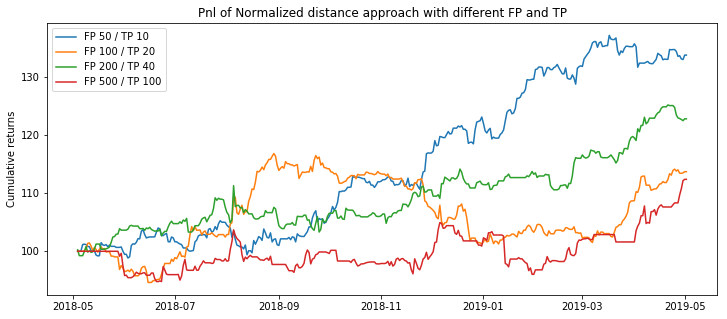

In [501]:
a = pd.date_range('2018-05-01 00:01:00+00:00','2018-05-04 00:01:00+00:00')
ind = performance2.sortino.dropna().index
ind = '2018-05-04 00:01:00+00:00'
p_val_1 = performance1.portfolio_value.loc[ind:].resample('D', convention='start').last()
p_val_2 = performance2.portfolio_value[ind:].resample('D', convention='start').last()
p_val_3 = performance3.portfolio_value[ind:].resample('D', convention='start').last()
p_val_4 = performance4.portfolio_value[ind:].resample('D', convention='start').last()
figure = plt.figure(figsize=[12,5])
plt.plot(p_val_4, label = "FP 50 / TP 10")
plt.plot(p_val_2, label = "FP 100 / TP 20")
plt.plot(p_val_1, label = "FP 200 / TP 40")
plt.plot(p_val_3, label = "FP 500 / TP 100")

plt.legend()
plt.title('Pnl of Normalized distance approach with different FP and TP')
plt.ylabel('Cumulative returns')
plt.show()

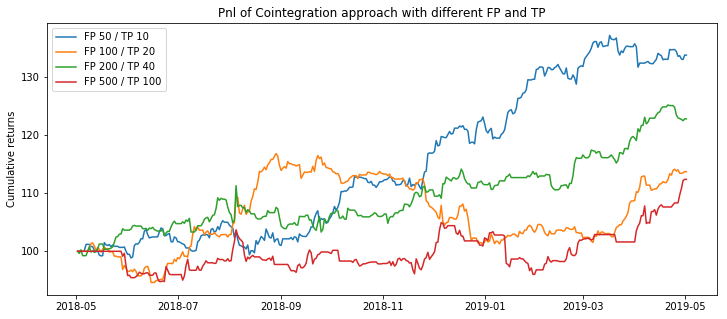

In [502]:
ind = '2018-05-01 00:01:00+00:00'
p_val_1 = performance1.portfolio_value.resample('D', convention='start').last()
p_val_2 = performance2.portfolio_value.resample('D', convention='start').last()
p_val_3 = performance3.portfolio_value.resample('D', convention='start').last()
p_val_4 = performance4.portfolio_value.resample('D', convention='start').last()
combined = pd.concat([p_val_1,p_val_2,p_val_3,p_val_4], axis=1)
combined = combined.loc[ind:,:].fillna(value=100)
figure = plt.figure(figsize=[12,5])
plt.plot(combined.iloc[:,3], label = "FP 50 / TP 10")
plt.plot(combined.iloc[:,1], label = "FP 100 / TP 20")
plt.plot(combined.iloc[:,0], label = "FP 200 / TP 40")
plt.plot(combined.iloc[:,2], label = "FP 500 / TP 100")

plt.legend()
plt.title('Pnl of Cointegration approach with different FP and TP')
plt.ylabel('Cumulative returns')
plt.show()

In [503]:
figure.savefig('/Users/vladimirbadlo/StatArb/plots/Sens/fptp_coint_new.png')

In [458]:
figure.savefig('/Users/vladimirbadlo/StatArb/plots/Sens/fptp_norm.png')

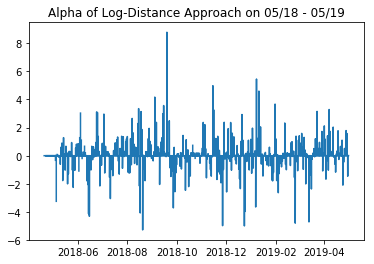

In [519]:
plt.figure()
plt.plot(performance.beta)
plt.title('Alpha of Log-Distance Approach on 05/18 - 05/19')
plt.show()

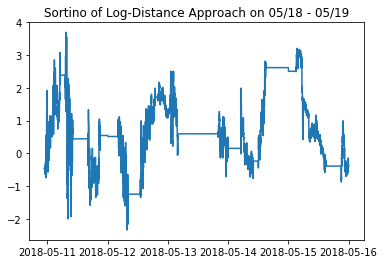

In [362]:
plt.figure()
plt.plot(performance.sortino.iloc[10000:])
plt.title('Sortino of Log-Distance Approach on 05/18 - 05/19')
plt.show()

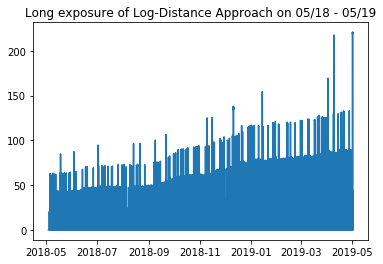

In [74]:
plt.figure()
plt.plot(performance.long_exposure)
plt.title('Long exposure of Log-Distance Approach on 05/18 - 05/19')
plt.show()

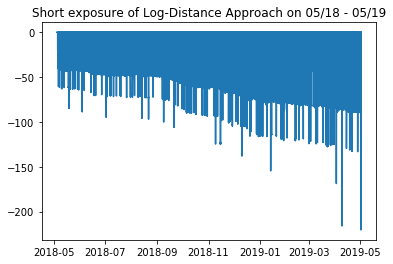

In [76]:
plt.figure()
plt.plot(performance.short_exposure)
plt.title('Short exposure of Log-Distance Approach on 05/18 - 05/19')
plt.show()

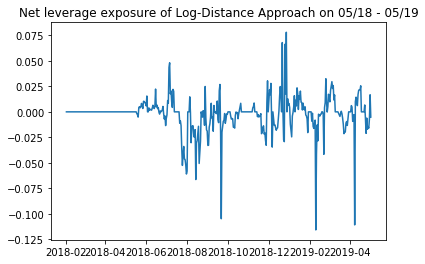

In [398]:
plt.figure()
plt.plot(performance.net_leverage)
plt.title('Net leverage exposure of Log-Distance Approach on 05/18 - 05/19')
plt.show()

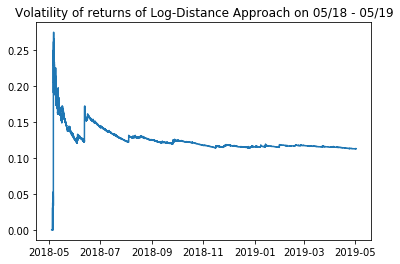

In [85]:
plt.figure()
plt.plot(performance.algo_volatility)
plt.title('Volatility of returns of Log-Distance Approach on 05/18 - 05/19')
plt.show()